In [99]:
# ---- GPU & TF memory tweaks
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

# Show GPU type (A100/T4/L4/etc.)
!nvidia-smi || true

# ---- Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# ---- Paths
BASE = "/content/drive/MyDrive/BraTS2020"
DATA_ZIP = f"{BASE}/brats20-dataset-training-validation.zip"
TRAIN_ROOT = f"{BASE}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
CKPT_DIR = "/content/drive/MyDrive/gliomascope_checkpoints"
LOG_DIR  = "/content/drive/MyDrive/gliomascope_logs"
!mkdir -p "{BASE}" "{CKPT_DIR}" "{LOG_DIR}"

Sun Oct 12 22:45:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             58W /  400W |   16891MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [101]:
!mkdir -p ~/.kaggle

# If the credentials exist in your Drive already, copy from there:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ 2>/dev/null || echo "kaggle.json not in Drive."

# Otherwise, write your creds directly (from your context)
import json, os
creds = {
    "username": "chandanmohan97",
    "key": "9a85890e9fc1699aedc7ce8bb6a7d766"
}
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(creds, f)

!chmod 600 ~/.kaggle/kaggle.json
!ls -lh ~/.kaggle

kaggle.json not in Drive.
total 4.0K
-rw------- 1 root root 73 Oct 12 22:48 kaggle.json


In [102]:
import os
from pathlib import Path

# Main dataset path
TRAIN_ROOT = "/content/drive/MyDrive/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Check existence
print("Path exists:", os.path.isdir(TRAIN_ROOT))

# Fix the BraTS20_Training_355 naming issue if needed
bad_file = Path(TRAIN_ROOT) / "BraTS20_Training_355" / "W39_1998.09.19_Segm.nii"
good_file = Path(TRAIN_ROOT) / "BraTS20_Training_355" / "BraTS20_Training_355_seg.nii"

if bad_file.exists() and not good_file.exists():
    bad_file.rename(good_file)
    print("✅ Renamed 355 segmentation file.")
else:
    print("✅ 355 segmentation file already fine or not present.")

# List a few sample case folders for confirmation
cases = sorted([p.name for p in Path(TRAIN_ROOT).glob("BraTS20_Training_*")])[:5]
print("Sample cases:", cases)

Path exists: True
✅ 355 segmentation file already fine or not present.
Sample cases: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']


In [103]:
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

# Dataset directory
TRAIN_ROOT = Path("/content/drive/MyDrive/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

# Collect all case folder names
case_dirs = sorted([p for p in TRAIN_ROOT.glob("BraTS20_Training_*") if p.is_dir()])
case_ids = [d.name for d in case_dirs]

# Split dataset
trainval_ids, val_ids = train_test_split(case_ids, test_size=0.20, random_state=42)
train_ids, test_ids   = train_test_split(trainval_ids, test_size=0.15, random_state=42)

print(f"Train: {len(train_ids)},  Val: {len(val_ids)},  Test: {len(test_ids)}")
print("Example train IDs:", train_ids[:5])

Train: 250,  Val: 74,  Test: 45
Example train IDs: ['BraTS20_Training_252', 'BraTS20_Training_025', 'BraTS20_Training_070', 'BraTS20_Training_067', 'BraTS20_Training_283']


In [104]:
import nibabel as nib
import cv2
import tensorflow as tf
import numpy as np
from pathlib import Path

IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22
N_CHANNELS = 2
N_CLASSES = 4

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, root_dir, batch_size=1, shuffle=True):
        self.ids = list_ids
        self.root = Path(root_dir)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.ids) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        X = np.zeros((self.batch_size*VOLUME_SLICES, IMG_SIZE, IMG_SIZE, N_CHANNELS), dtype=np.float32)
        Y = np.zeros((self.batch_size*VOLUME_SLICES, IMG_SIZE, IMG_SIZE, N_CLASSES), dtype=np.float32)

        for b, bi in enumerate(batch_indexes):
            case = self.ids[bi]
            case_dir = self.root / case

            # Load modalities
            flair = nib.load(str(case_dir / f"{case}_flair.nii")).get_fdata().astype(np.float32)
            t1ce  = nib.load(str(case_dir / f"{case}_t1ce.nii")).get_fdata().astype(np.float32)
            seg   = nib.load(str(case_dir / f"{case}_seg.nii")).get_fdata()

            # Per-volume normalization
            def norm(v):
                vmin, vmax = np.min(v), np.max(v)
                return (v - vmin) / (vmax - vmin + 1e-8) if vmax > vmin else np.zeros_like(v)

            flair = norm(flair)
            t1ce  = norm(t1ce)

            for j in range(VOLUME_SLICES):
                s = j + VOLUME_START_AT
                X[b*VOLUME_SLICES + j, :, :, 0] = cv2.resize(flair[:, :, s], (IMG_SIZE, IMG_SIZE))
                X[b*VOLUME_SLICES + j, :, :, 1] = cv2.resize(t1ce[:, :, s], (IMG_SIZE, IMG_SIZE))

                m = seg[:, :, s].copy()
                m[m == 4] = 3
                m = cv2.resize(m, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                Y[b*VOLUME_SLICES + j] = tf.one_hot(m.astype(np.int32), depth=N_CLASSES).numpy()

        return X, Y

# Instantiate generators
TRAIN_ROOT = "/content/drive/MyDrive/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
train_gen = DataGenerator(train_ids, TRAIN_ROOT)
val_gen   = DataGenerator(val_ids, TRAIN_ROOT)
test_gen  = DataGenerator(test_ids, TRAIN_ROOT)

print("Train batches per epoch:", len(train_gen))

Train batches per epoch: 250


Example case: BraTS20_Training_252


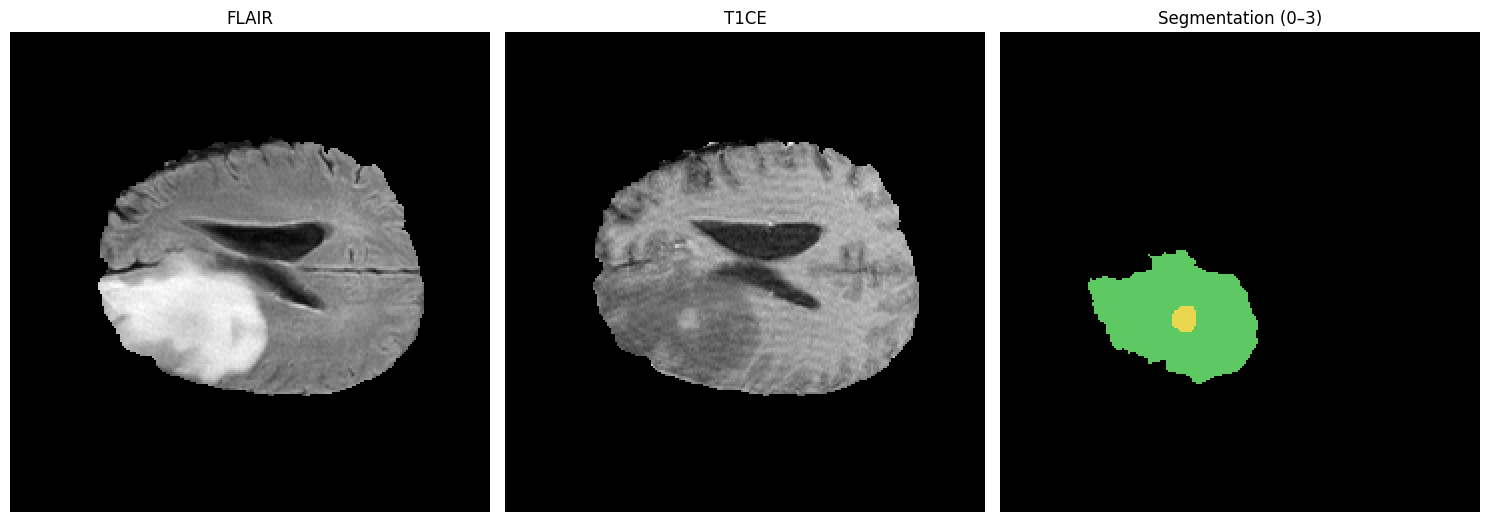

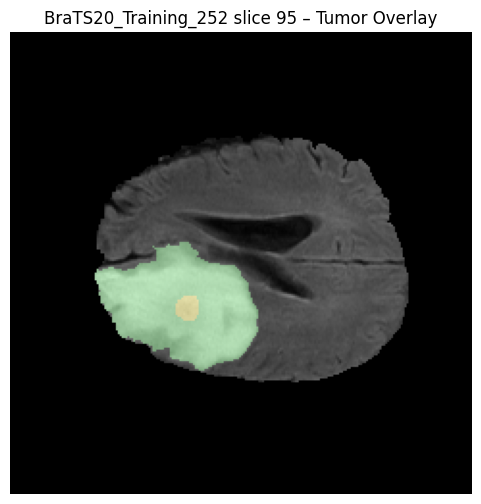

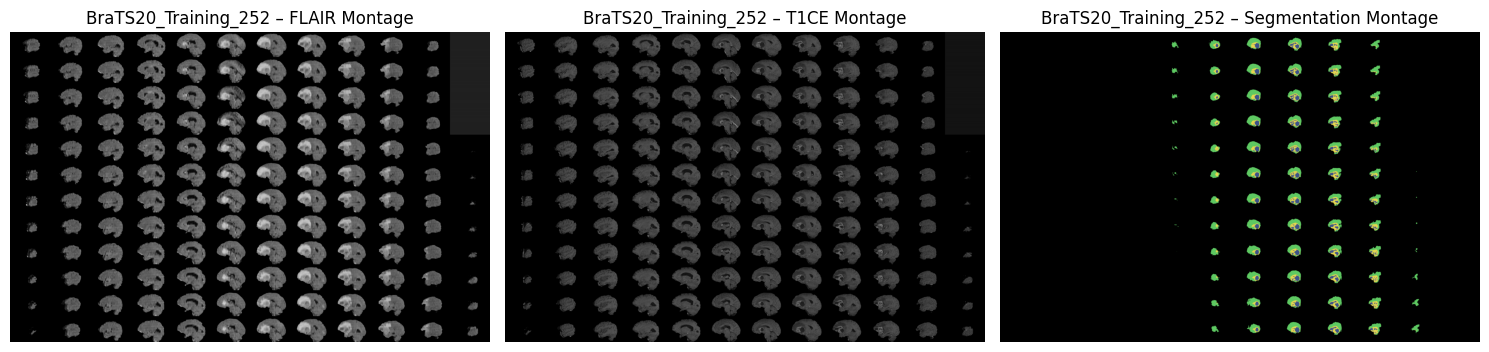

In [105]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import nibabel as nib
import cv2
from skimage.util import montage
from pathlib import Path

TRAIN_ROOT = Path("/content/drive/MyDrive/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

# --- define colormap for segmentation
tumor_cmap = mcolors.ListedColormap(['#000000', '#3b528b', '#5ec962', '#e6d74f'])
tumor_norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], tumor_cmap.N)

def visualize_case(case_id: str, slice_idx: int = 95, montage_view: bool = False):
    """
    Visualizes FLAIR, T1CE, and segmentation slices for a BraTS case.
    Set montage_view=True to show multiple slices.
    """
    case_dir = TRAIN_ROOT / case_id
    flair = nib.load(str(case_dir / f"{case_id}_flair.nii")).get_fdata()
    t1ce  = nib.load(str(case_dir / f"{case_id}_t1ce.nii")).get_fdata()
    seg   = nib.load(str(case_dir / f"{case_id}_seg.nii")).get_fdata()

    # Replace label 4 -> 3 for consistency
    seg[seg == 4] = 3

    if montage_view:
        fig, ax = plt.subplots(1, 3, figsize=(15, 8))
        ax[0].imshow(np.rot90(montage(flair[50:-50,:,:])), cmap='gray')
        ax[0].set_title(f"{case_id} – FLAIR Montage")
        ax[1].imshow(np.rot90(montage(t1ce[50:-50,:,:])), cmap='gray')
        ax[1].set_title(f"{case_id} – T1CE Montage")
        ax[2].imshow(np.rot90(montage(seg[50:-50,:,:])), cmap=tumor_cmap, norm=tumor_norm)
        ax[2].set_title(f"{case_id} – Segmentation Montage")
        for a in ax: a.axis('off')
        plt.tight_layout()
        plt.show()
        return

    # ---- single slice view
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    flair_slice = flair[:,:,slice_idx]
    t1ce_slice  = t1ce[:,:,slice_idx]
    seg_slice   = seg[:,:,slice_idx]

    axes[0].imshow(flair_slice, cmap='gray')
    axes[0].set_title("FLAIR")

    axes[1].imshow(t1ce_slice, cmap='gray')
    axes[1].set_title("T1CE")

    axes[2].imshow(seg_slice, cmap=tumor_cmap, norm=tumor_norm)
    axes[2].set_title("Segmentation (0–3)")
    for a in axes: a.axis('off')
    plt.tight_layout()
    plt.show()

def overlay_tumor(case_id: str, slice_idx: int = 95):
    """
    Shows FLAIR grayscale with segmentation overlay.
    """
    case_dir = TRAIN_ROOT / case_id
    flair = nib.load(str(case_dir / f"{case_id}_flair.nii")).get_fdata()
    seg   = nib.load(str(case_dir / f"{case_id}_seg.nii")).get_fdata()
    seg[seg == 4] = 3

    flair_slice = flair[:,:,slice_idx]
    seg_slice   = seg[:,:,slice_idx]

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.imshow(flair_slice, cmap='gray')
    ax.imshow(seg_slice, cmap=tumor_cmap, norm=tumor_norm, alpha=0.4)
    ax.set_title(f"{case_id} slice {slice_idx} – Tumor Overlay")
    ax.axis('off')
    plt.show()

# --- Example usage
example_case = train_ids[0]
print("Example case:", example_case)
visualize_case(example_case, slice_idx=95)
overlay_tumor(example_case, slice_idx=95)
visualize_case(example_case, montage_view=True)

In [106]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model

# --- Config (reuse from earlier)
IMG_SIZE   = 128
N_CHANNELS = 2
N_CLASSES  = 4

# ---------- Metrics ----------
def dice_coef(y_true, y_pred, smooth=1.0):
    # Macro Dice over all classes
    scores = []
    for i in range(N_CLASSES):
        yt = K.flatten(y_true[..., i])
        yp = K.flatten(y_pred[..., i])
        inter = K.sum(yt * yp)
        denom = K.sum(yt) + K.sum(yp)
        scores.append((2.0 * inter + smooth) / (denom + smooth))
    return tf.add_n(scores) / float(N_CLASSES)

def dice_class(i, eps=1e-6):
    # Per-class Dice (i: 0..3)
    def _f(y_true, y_pred):
        inter = K.sum(K.abs(y_true[..., i] * y_pred[..., i]))
        return (2.0 * inter) / (K.sum(K.square(y_true[..., i])) + K.sum(K.square(y_pred[..., i])) + eps)
    _f.__name__ = f"dice_class_{i}"
    return _f

def precision(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return tp / (pp + K.epsilon())

def sensitivity(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    return tp / (pos + K.epsilon())

def specificity(y_true, y_pred):
    tn  = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    neg = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return tn / (neg + K.epsilon())

# ---------- Model ----------
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS), dropout=0.2):
    inp = Input(input_shape)

    c1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inp)
    c1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c1)

    p2 = MaxPooling2D()(c1)
    c2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c2)

    p3 = MaxPooling2D()(c2)
    c3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c3)

    p4 = MaxPooling2D()(c3)
    c4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c4)

    p5 = MaxPooling2D()(c4)
    c5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p5)
    c5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    d5 = Dropout(dropout)(c5)

    u6 = UpSampling2D()(d5);  u6 = Conv2D(256, 2, activation='relu', padding='same')(u6)
    m6 = concatenate([c4, u6]); c6 = Conv2D(256, 3, activation='relu', padding='same')(m6); c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6);  u7 = Conv2D(128, 2, activation='relu', padding='same')(u7)
    m7 = concatenate([c3, u7]); c7 = Conv2D(128, 3, activation='relu', padding='same')(m7); c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)

    u8 = UpSampling2D()(c7);  u8 = Conv2D(64, 2, activation='relu', padding='same')(u8)
    m8 = concatenate([c2, u8]); c8 = Conv2D(64, 3, activation='relu', padding='same')(m8); c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)

    u9 = UpSampling2D()(c8);  u9 = Conv2D(32, 2, activation='relu', padding='same')(u9)
    m9 = concatenate([c1, u9]); c9 = Conv2D(32, 3, activation='relu', padding='same')(m9); c9 = Conv2D(32, 3, activation='relu', padding='same')(c9)

    out = Conv2D(N_CLASSES, 1, activation='softmax')(c9)
    return Model(inp, out)

model = build_unet()
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=N_CLASSES),
        dice_coef, precision, sensitivity, specificity,
        dice_class(1), dice_class(2), dice_class(3)  # per-class dice for tumor classes
    ]
)
model.summary(line_length=120)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 128, 128, 2)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d (Conv2D)                   │ (None, 128, 128, 32)         │               608 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_1 (Conv2D)                 │ (None, 128, 128, 32)         │             9,248 │ conv2d[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d (MaxPooling2D)      │ (None, 64, 64, 32)           │                 0 │ conv2d_1[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_2 (Conv2D)                 │ (None, 64, 64, 64)           │            18,496 │ max_pooling2d[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_3 (Conv2D)                 │ (None, 64, 64, 64)           │            36,928 │ conv2d_2[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d_1 (MaxPooling2D)    │ (None, 32, 32, 64)           │                 0 │ conv2d_3[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_4 (Conv2D)                 │ (None, 32, 32, 128)          │            73,856 │ max_pooling2d_1[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_5 (Conv2D)                 │ (None, 32, 32, 128)          │           147,584 │ conv2d_4[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d_2 (MaxPooling2D)    │ (None, 16, 16, 128)          │                 0 │ conv2d_5[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_6 (Conv2D)                 │ (None, 16, 16, 256)          │           295,168 │ max_pooling2d_2[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_7 (Conv2D)                 │ (None, 16, 16, 256)          │           590,080 │ conv2d_6[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d_3 (MaxPooling2D)    │ (None, 8, 8, 256)            │                 0 │ conv2d_7[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_8 (Conv2D)                 │ (None, 8, 8, 512)            │         1,180,160 │ max_pooling2d_3[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_9 (Conv2D)                 │ (None, 8, 8, 512)            │         2,359,808 │ conv2d_8[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout (Dropout)                 │ (None, 8, 8, 512)            │                 0 │ conv2d_9[0][0]            
├───────────────────────────────────┼───────────────────

 Total params: 7,759,908 (29.60 MB)

 Trainable params: 7,759,908 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
import glob, re
from pathlib import Path
import tensorflow as tf

CKPT_DIR = Path("/content/drive/MyDrive/gliomascope_checkpoints")
LOG_DIR  = Path("/content/drive/MyDrive/gliomascope_logs")
CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

# Save best weights by val_loss
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(CKPT_DIR / "gsrx_epoch_{epoch:03d}_valloss_{val_loss:.5f}.weights.h5"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
    verbose=1,
)

csv_cb = tf.keras.callbacks.CSVLogger(str(LOG_DIR / "training_log.csv"), append=True)
lr_cb  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

def latest_ckpt():
    files = glob.glob(str(CKPT_DIR / "gsrx_epoch_*.weights.h5"))
    if not files: return None
    def epoch_of(p):
        m = re.search(r"gsrx_epoch_(\d{3})_", Path(p).name)
        return int(m.group(1)) if m else -1
    files.sort(key=epoch_of)
    return files[-1]

last = latest_ckpt()
if last:
    print("Resuming from:", last)
    model.load_weights(last)
else:
    print("No previous checkpoint found; training from scratch.")

No previous checkpoint found; training from scratch.


In [109]:
E1 = 5
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=E1,
    callbacks=[checkpoint_cb, csv_cb, lr_cb]
)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9657 - dice_class_1: 0.0413 - dice_class_2: 0.1124 - dice_class_3: 0.0297 - dice_coef: 0.2565 - loss: 0.2068 - mean_io_u: 0.5933 - precision: 0.9593 - sensitivity: 0.9304 - specificity: 0.9949
Epoch 1: val_loss improved from inf to 0.06319, saving model to /content/drive/MyDrive/gliomascope_checkpoints/gsrx_epoch_001_valloss_0.06319.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1075s 4s/step - accuracy: 0.9658 - dice_class_1: 0.0414 - dice_class_2: 0.1126 - dice_class_3: 0.0297 - dice_coef: 0.2566 - loss: 0.2064 - mean_io_u: 0.5937 - precision: 0.9594 - sensitivity: 0.9306 - specificity: 0.9949 - val_accuracy: 0.9836 - val_dice_class_1: 0.1232 - val_dice_class_2: 0.2982 - val_dice_class_3: 0.0672 - val_dice_coef: 0.3109 - val_loss: 0.0632 - val_mean_io_u: 0.7772 - val_precision: 0.9878 - val_sensitivity: 0.9786 - val_specificity: 0.9960 - learning_rate: 0.0010
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.98

In [110]:
last = latest_ckpt()
if last:
    print("Resuming from:", last)
    model.load_weights(last)
else:
    print("Starting from current model state (no checkpoint found).")

E2 = 30  # Continue training for 30 epochs
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=E2,
    callbacks=[checkpoint_cb, csv_cb, lr_cb]
)

Resuming from: /content/drive/MyDrive/gliomascope_checkpoints/gsrx_epoch_004_valloss_0.05463.weights.h5
Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9843 - dice_class_1: 0.1453 - dice_class_2: 0.3314 - dice_class_3: 0.1126 - dice_coef: 0.3341 - loss: 0.0515 - mean_io_u: 0.5241 - precision: 0.9885 - sensitivity: 0.9811 - specificity: 0.9962
Epoch 1: val_loss improved from 0.05463 to 0.04836, saving model to /content/drive/MyDrive/gliomascope_checkpoints/gsrx_epoch_001_valloss_0.04836.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 428ms/step - accuracy: 0.9843 - dice_class_1: 0.1454 - dice_class_2: 0.3314 - dice_class_3: 0.1126 - dice_coef: 0.3341 - loss: 0.0515 - mean_io_u: 0.5242 - precision: 0.9885 - sensitivity: 0.9811 - specificity: 0.9962 - val_accuracy: 0.9850 - val_dice_class_1: 0.2227 - val_dice_class_2: 0.3794 - val_dice_class_3: 0.1838 - val_dice_coef: 0.3678 - val_loss: 0.0484 - val_mean_io_u: 0.4202 - val_precision: 0.9914 - val_sensitivity: 0.9801 - val

In [111]:
BEST_WEIGHTS = "/content/drive/MyDrive/gliomascope_checkpoints/gsrx_epoch_028_valloss_0.02257.weights.h5"

model.load_weights(BEST_WEIGHTS)
model.save("/content/drive/MyDrive/GliomaScopeRX_BraTS2020_final.keras")

print("✅ Saved:", "/content/drive/MyDrive/GliomaScopeRX_BraTS2020_final.keras")

✅ Saved: /content/drive/MyDrive/GliomaScopeRX_BraTS2020_final.keras


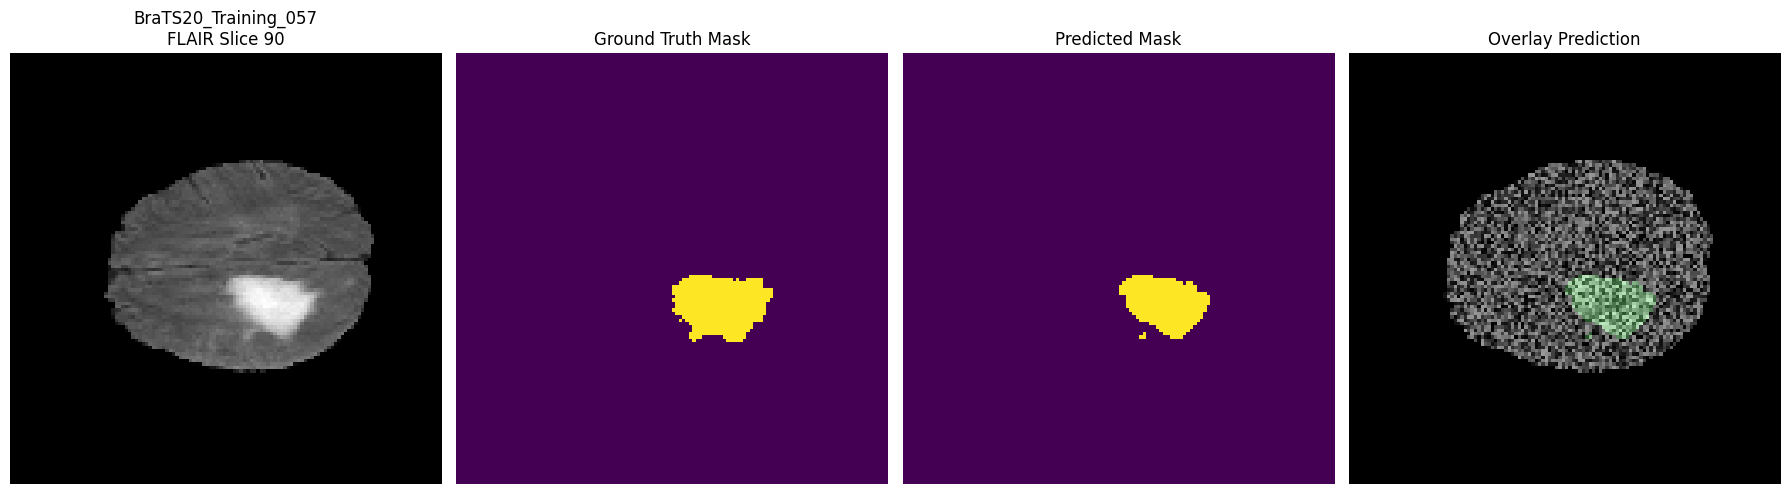

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pathlib import Path
import cv2
import nibabel as nib
import random

# === Paths & constants
BEST_WEIGHTS = "/content/drive/MyDrive/gliomascope_checkpoints/gsrx_epoch_028_valloss_0.02257.weights.h5"
TRAIN_ROOT = Path("/content/drive/MyDrive/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

IMG_SIZE = 128
N_CLASSES = 4
tumor_colors = {
    0: (0, 0, 0),        # background - black
    1: (59, 82, 139),    # necrotic/core - blue
    2: (94, 201, 98),    # edema - green
    3: (230, 215, 79)    # enhancing - yellow
}

# === Load model
model.load_weights(BEST_WEIGHTS)

def predict_case(case_id, slice_idx=90):
    case_dir = TRAIN_ROOT / case_id
    flair = nib.load(str(case_dir / f"{case_id}_flair.nii")).get_fdata()
    t1ce  = nib.load(str(case_dir / f"{case_id}_t1ce.nii")).get_fdata()
    seg   = nib.load(str(case_dir / f"{case_id}_seg.nii")).get_fdata()
    seg[seg==4] = 3

    flair_slice = cv2.resize(flair[:,:,slice_idx], (IMG_SIZE, IMG_SIZE))
    t1ce_slice  = cv2.resize(t1ce[:,:,slice_idx], (IMG_SIZE, IMG_SIZE))
    seg_slice   = cv2.resize(seg[:,:,slice_idx], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    X = np.stack([flair_slice, t1ce_slice], axis=-1)[None,...]
    X = (X - X.min()) / (X.max() - X.min() + 1e-8)
    pred = model.predict(X, verbose=0)[0].argmax(axis=-1)

    return flair_slice, seg_slice, pred

def overlay_mask(image, mask, alpha=0.4):
    image_rgb = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    overlay = image_rgb.copy()
    for label, color in tumor_colors.items():
        overlay[mask==label] = color
    return cv2.addWeighted(overlay, alpha, image_rgb, 1-alpha, 0)

def show_prediction(case_id=None, slice_idx=None):
    if case_id is None: case_id = random.choice(val_ids)
    if slice_idx is None: slice_idx = random.randint(70,110)
    flair, true_mask, pred_mask = predict_case(case_id, slice_idx)
    overlay_pred = overlay_mask(flair, pred_mask)
    overlay_true = overlay_mask(flair, true_mask)

    fig, ax = plt.subplots(1,4, figsize=(18,6))
    ax[0].imshow(flair, cmap='gray'); ax[0].set_title(f"{case_id}\nFLAIR Slice {slice_idx}")
    ax[1].imshow(true_mask, cmap='viridis'); ax[1].set_title("Ground Truth Mask")
    ax[2].imshow(pred_mask, cmap='viridis'); ax[2].set_title("Predicted Mask")
    ax[3].imshow(overlay_pred); ax[3].set_title("Overlay Prediction")
    for a in ax: a.axis('off')
    plt.tight_layout(); plt.show()

# === Example
show_prediction()   # pick random validation case

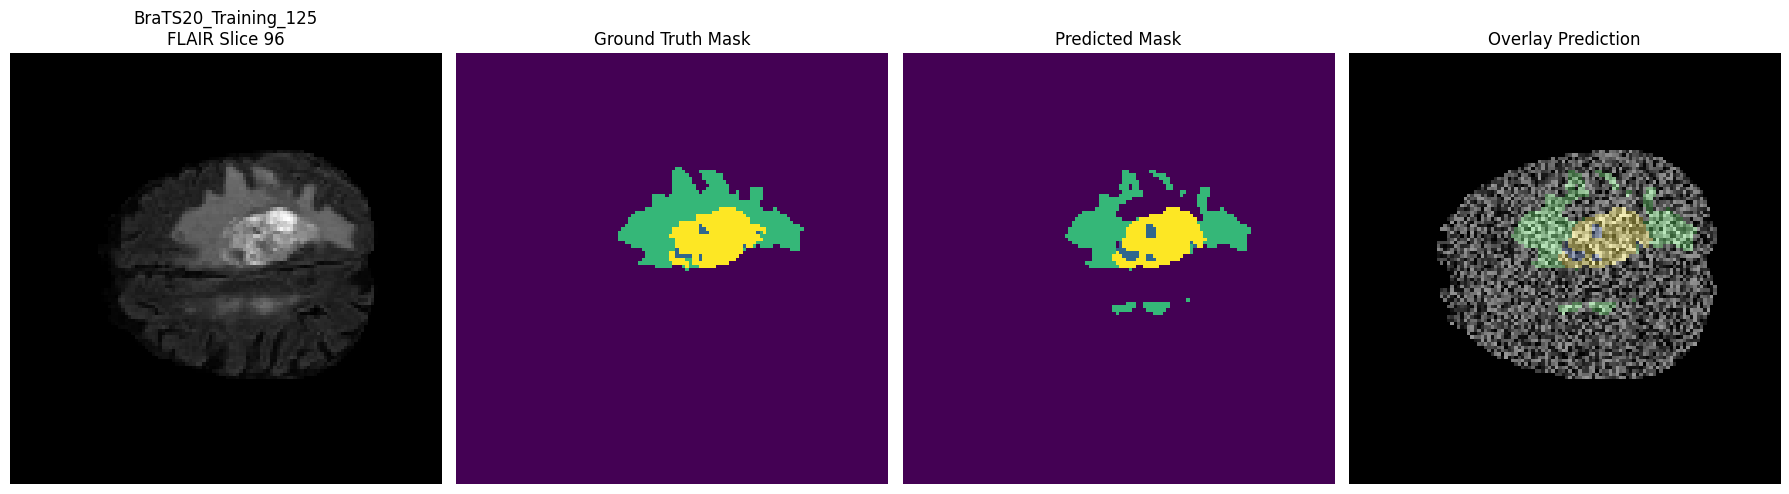

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pathlib import Path
import cv2
import nibabel as nib
import random

# === Paths & constants
BEST_WEIGHTS = "/content/drive/MyDrive/gliomascope_checkpoints/gsrx_epoch_028_valloss_0.02257.weights.h5"
TRAIN_ROOT = Path("/content/drive/MyDrive/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

IMG_SIZE = 128
N_CLASSES = 4
tumor_colors = {
    0: (0, 0, 0),        # background - black
    1: (59, 82, 139),    # necrotic/core - blue
    2: (94, 201, 98),    # edema - green
    3: (230, 215, 79)    # enhancing - yellow
}

# === Load model
model.load_weights(BEST_WEIGHTS)

def predict_case(case_id, slice_idx=90):
    case_dir = TRAIN_ROOT / case_id
    flair = nib.load(str(case_dir / f"{case_id}_flair.nii")).get_fdata()
    t1ce  = nib.load(str(case_dir / f"{case_id}_t1ce.nii")).get_fdata()
    seg   = nib.load(str(case_dir / f"{case_id}_seg.nii")).get_fdata()
    seg[seg==4] = 3

    flair_slice = cv2.resize(flair[:,:,slice_idx], (IMG_SIZE, IMG_SIZE))
    t1ce_slice  = cv2.resize(t1ce[:,:,slice_idx], (IMG_SIZE, IMG_SIZE))
    seg_slice   = cv2.resize(seg[:,:,slice_idx], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    X = np.stack([flair_slice, t1ce_slice], axis=-1)[None,...]
    X = (X - X.min()) / (X.max() - X.min() + 1e-8)
    pred = model.predict(X, verbose=0)[0].argmax(axis=-1)

    return flair_slice, seg_slice, pred

def overlay_mask(image, mask, alpha=0.4):
    image_rgb = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    overlay = image_rgb.copy()
    for label, color in tumor_colors.items():
        overlay[mask==label] = color
    return cv2.addWeighted(overlay, alpha, image_rgb, 1-alpha, 0)

def show_prediction(case_id=None, slice_idx=None):
    if case_id is None: case_id = random.choice(val_ids)
    if slice_idx is None: slice_idx = random.randint(70,110)
    flair, true_mask, pred_mask = predict_case(case_id, slice_idx)
    overlay_pred = overlay_mask(flair, pred_mask)
    overlay_true = overlay_mask(flair, true_mask)

    fig, ax = plt.subplots(1,4, figsize=(18,6))
    ax[0].imshow(flair, cmap='gray'); ax[0].set_title(f"{case_id}\nFLAIR Slice {slice_idx}")
    ax[1].imshow(true_mask, cmap='viridis'); ax[1].set_title("Ground Truth Mask")
    ax[2].imshow(pred_mask, cmap='viridis'); ax[2].set_title("Predicted Mask")
    ax[3].imshow(overlay_pred); ax[3].set_title("Overlay Prediction")
    for a in ax: a.axis('off')
    plt.tight_layout(); plt.show()

# === Example
show_prediction()   # pick random validation case

In [113]:
import numpy as np, cv2, nibabel as nib
from pathlib import Path
import random, os
import matplotlib.pyplot as plt

EXPORT_DIR = Path("/content/drive/MyDrive/GliomaScopeRX_Exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

BEST_WEIGHTS = "/content/drive/MyDrive/gliomascope_checkpoints/gsrx_epoch_028_valloss_0.02257.weights.h5"
TRAIN_ROOT = Path("/content/drive/MyDrive/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

model.load_weights(BEST_WEIGHTS)

def export_case(case_id=None, slice_idx=None, outdir=EXPORT_DIR):
    if case_id is None: case_id = random.choice(val_ids)
    if slice_idx is None: slice_idx = random.randint(70,110)

    case_dir = TRAIN_ROOT / case_id
    flair = nib.load(str(case_dir / f"{case_id}_flair.nii")).get_fdata()
    t1ce  = nib.load(str(case_dir / f"{case_id}_t1ce.nii")).get_fdata()
    seg   = nib.load(str(case_dir / f"{case_id}_seg.nii")).get_fdata()
    seg[seg==4] = 3

    flair_slice = cv2.resize(flair[:,:,slice_idx], (IMG_SIZE, IMG_SIZE))
    t1ce_slice  = cv2.resize(t1ce[:,:,slice_idx], (IMG_SIZE, IMG_SIZE))
    seg_slice   = cv2.resize(seg[:,:,slice_idx], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    X = np.stack([flair_slice, t1ce_slice], axis=-1)[None,...]
    X = (X - X.min()) / (X.max() - X.min() + 1e-8)
    pred = model.predict(X, verbose=0)[0].argmax(axis=-1)

    overlay = overlay_mask(flair_slice, pred)

    case_folder = outdir / case_id
    case_folder.mkdir(exist_ok=True)

    # save bundle
    np.savez_compressed(
        case_folder / f"slice_{slice_idx}.npz",
        flair=flair_slice.astype(np.float32),
        true_mask=seg_slice.astype(np.uint8),
        pred_mask=pred.astype(np.uint8),
        overlay=overlay.astype(np.uint8),
    )

    # save preview PNGs
    cv2.imwrite(str(case_folder / f"flair_{slice_idx}.png"), (flair_slice*255).astype(np.uint8))
    cv2.imwrite(str(case_folder / f"pred_{slice_idx}.png"), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    print(f"✅ Exported {case_id} slice {slice_idx} → {case_folder}")

# --- Export random 5 examples
for _ in range(5):
    export_case()

✅ Exported BraTS20_Training_083 slice 94 → /content/drive/MyDrive/GliomaScopeRX_Exports/BraTS20_Training_083
✅ Exported BraTS20_Training_334 slice 101 → /content/drive/MyDrive/GliomaScopeRX_Exports/BraTS20_Training_334
✅ Exported BraTS20_Training_110 slice 90 → /content/drive/MyDrive/GliomaScopeRX_Exports/BraTS20_Training_110
✅ Exported BraTS20_Training_138 slice 104 → /content/drive/MyDrive/GliomaScopeRX_Exports/BraTS20_Training_138
✅ Exported BraTS20_Training_156 slice 74 → /content/drive/MyDrive/GliomaScopeRX_Exports/BraTS20_Training_156


In [115]:
!find /content/drive/MyDrive -maxdepth 3 -type f -name "GliomaScopeRX_BraTS2020_Full.zip"

In [116]:
!ls /content/drive

MyDrive


In [117]:
!ls -lh /content/drive/MyDrive

total 4.6G
-rw------- 1 root root  180 Apr 22  2020 'ADDRESSING IMPACTS OF COVID19.gslides'
-rw------- 1 root root  180 Aug 28  2019 'Book report.gslides'
drwx------ 4 root root 4.0K Oct 12 21:39  BraTS2020
drwx------ 2 root root 4.0K Nov 10  2024 'Colab Notebooks'
-rw------- 1 root root 160K Aug  7  2024 'Copy of 404893117_866107928497078_3435784728347626671_n.jpg'
drwx------ 3 root root 4.0K Nov 10  2024 'Fall 24 (sem 3)'
drwx------ 2 root root 4.0K Oct 13 00:19  gliomascope_checkpoints
drwx------ 2 root root 4.0K Oct 13 00:23  gliomascope_logs
-rw------- 1 root root  89M Oct 13 00:28  GliomaScopeRX_BraTS2020_final.keras
drwx------ 7 root root 4.0K Oct 13 00:30  GliomaScopeRX_Exports
-rw------- 1 root root 2.9M Aug 11  2014 'How to get started with Drive.pdf'
-rw------- 1 root root  180 Apr 21  2020 'Lesson plan.gslides'
drwx------ 2 root root 4.0K Aug 19  2019 'New folder'
drwx------ 2 root root 4.0K Aug  7  2024 'Saved from Chrome'
-rw------- 1 root root   25 Aug 30  2024  Scratchp

✅ Model loaded successfully.
📤 Upload your MRI slice(s) (FLAIR and/or T1CE JPEGs)


Saving Tr-gl_1309.jpg to Tr-gl_1309.jpg

Using:
FLAIR → Tr-gl_1309.jpg
T1CE  → Tr-gl_1309.jpg


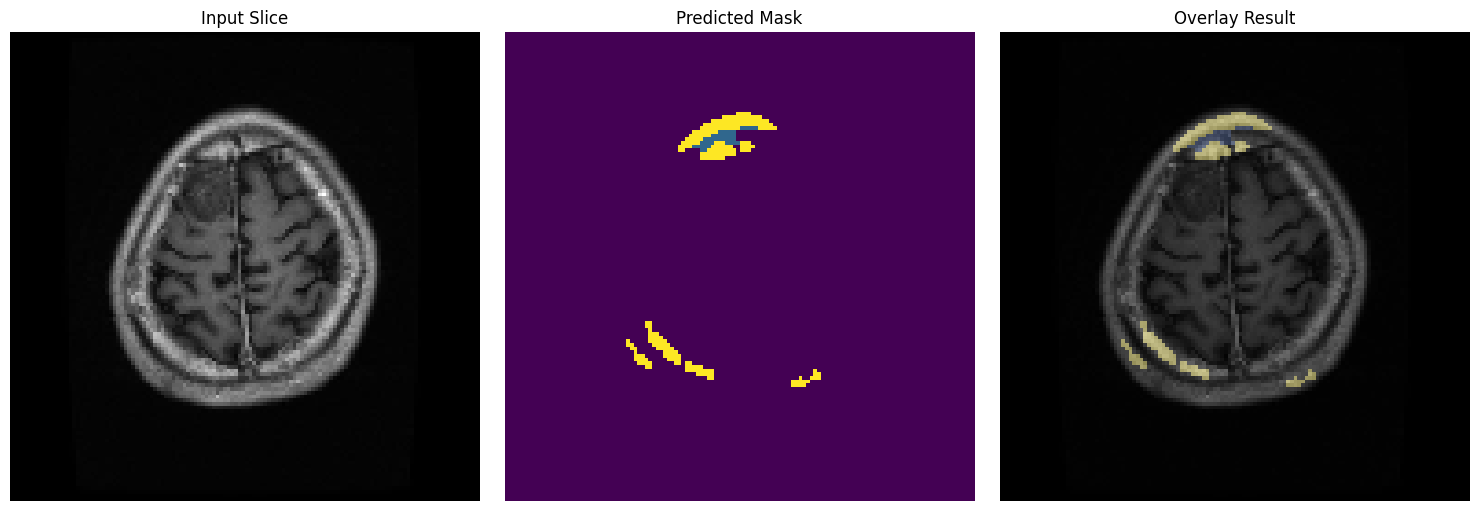

✅ Saved overlay → /content/pred_overlay.jpg


In [120]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from pathlib import Path

# === CONFIG ===
MODEL_PATH = "/content/drive/MyDrive/GliomaScopeRX_BraTS2020_final.keras"
IMG_SIZE = 128
N_CLASSES = 4

# Load model
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully.")

# Colors for tumor classes
tumor_colors = {
    0: (0, 0, 0),        # background
    1: (59, 82, 139),    # necrotic/core
    2: (94, 201, 98),    # edema
    3: (230, 215, 79)    # enhancing
}

def preprocess_image(image_path):
    """Load, normalize, and resize an image safely."""
    if not Path(image_path).exists():
        raise FileNotFoundError(f"❌ File not found: {image_path}")
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"❌ Unable to read image: {image_path}")
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-8)
    return img_norm

def predict_from_jpeg(flair=None, t1ce=None):
    """Runs inference on one or two JPEGs."""
    if flair is None and t1ce is None:
        raise ValueError("Upload at least one image (FLAIR or T1CE).")

    # if only one image uploaded, duplicate channel
    if flair is None:
        flair = t1ce
    if t1ce is None:
        t1ce = flair

    f = preprocess_image(flair)
    t = preprocess_image(t1ce)
    X = np.stack([f, t], axis=-1)[None, ...]
    pred = model.predict(X, verbose=0)[0].argmax(axis=-1)
    return f, pred

def overlay_mask(image, mask, alpha=0.4):
    """Apply color overlay mask."""
    image_rgb = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    overlay = image_rgb.copy()
    for label, color in tumor_colors.items():
        overlay[mask == label] = color
    return cv2.addWeighted(overlay, alpha, image_rgb, 1 - alpha, 0)

def visualize_result(image, mask):
    """Display grayscale, mask, and overlay."""
    overlay = overlay_mask(image, mask)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image, cmap="gray"); ax[0].set_title("Input Slice")
    ax[1].imshow(mask, cmap="viridis"); ax[1].set_title("Predicted Mask")
    ax[2].imshow(overlay); ax[2].set_title("Overlay Result")
    for a in ax: a.axis("off")
    plt.tight_layout()
    plt.show()
    return overlay

# === Upload section ===
print("📤 Upload your MRI slice(s) (FLAIR and/or T1CE JPEGs)")
uploaded = files.upload()

paths = list(uploaded.keys())
flair_path = paths[0] if len(paths) > 0 else None
t1ce_path  = paths[1] if len(paths) > 1 else None

print(f"\nUsing:\nFLAIR → {flair_path}\nT1CE  → {t1ce_path or flair_path}")

# Run inference
flair, pred = predict_from_jpeg(flair=flair_path, t1ce=t1ce_path)
overlay = visualize_result(flair, pred)

# Save output
out_path = "/content/pred_overlay.jpg"
cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print(f"✅ Saved overlay → {out_path}")

✅ Model loaded successfully.
📤 Upload FLAIR, T1CE, and (optional) ground truth mask JPEG/PNG


Saving Tr-me_1334.jpg to Tr-me_1334.jpg

Using:
FLAIR → Tr-me_1334.jpg
T1CE  → Tr-me_1334.jpg
Mask  → None


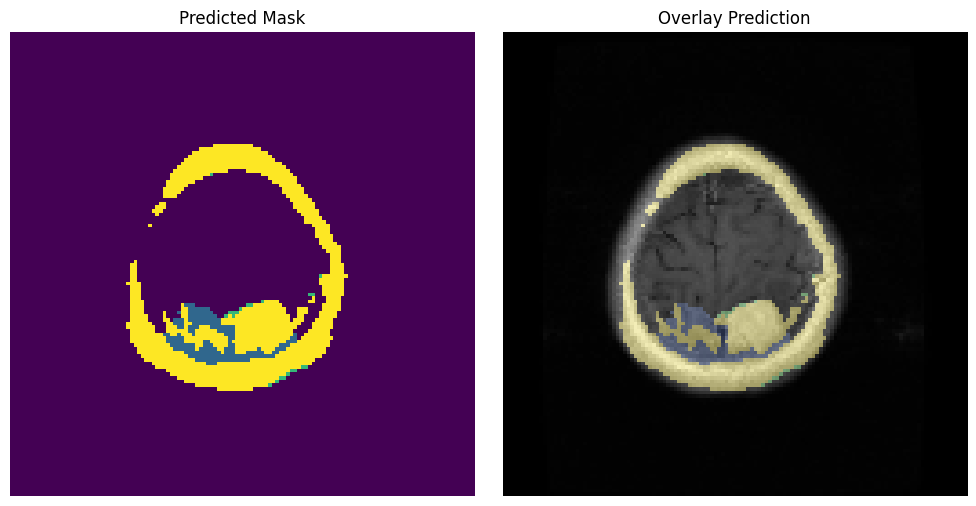

✅ Saved overlay → /content/pred_overlay.jpg


In [123]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from pathlib import Path

# === CONFIG ===
MODEL_PATH = "/content/drive/MyDrive/GliomaScopeRX_BraTS2020_final.keras"
IMG_SIZE = 128
N_CLASSES = 4

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully.")

tumor_colors = {
    0: (0, 0, 0),
    1: (59, 82, 139),
    2: (94, 201, 98),
    3: (230, 215, 79)
}

def preprocess_image(image_path):
    if not Path(image_path).exists():
        raise FileNotFoundError(f"❌ File not found: {image_path}")
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"❌ Unable to read image: {image_path}")
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-8)
    return img_norm

def preprocess_mask(mask_path):
    """Load and resize mask (values should be 0–3)."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"❌ Unable to read mask: {mask_path}")
    mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    return mask_resized

def predict_from_jpeg(flair=None, t1ce=None):
    if flair is None and t1ce is None:
        raise ValueError("Upload at least one MRI slice (FLAIR or T1CE).")
    if flair is None: flair = t1ce
    if t1ce is None: t1ce = flair
    f = preprocess_image(flair)
    t = preprocess_image(t1ce)
    X = np.stack([f, t], axis=-1)[None, ...]
    pred = model.predict(X, verbose=0)[0].argmax(axis=-1)
    return f, pred

def overlay_mask(image, mask, alpha=0.4):
    image_rgb = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    overlay = image_rgb.copy()
    for label, color in tumor_colors.items():
        overlay[mask == label] = color
    return cv2.addWeighted(overlay, alpha, image_rgb, 1 - alpha, 0)

def visualize_comparison(flair, pred, gt=None):
    overlay = overlay_mask(flair, pred)

    if gt is not None:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(gt, cmap="viridis"); ax[0].set_title("Ground Truth Mask")
        ax[1].imshow(pred, cmap="viridis"); ax[1].set_title("Predicted Mask")
        ax[2].imshow(overlay); ax[2].set_title("Overlay Prediction")
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(pred, cmap="viridis"); ax[0].set_title("Predicted Mask")
        ax[1].imshow(overlay); ax[1].set_title("Overlay Prediction")

    for a in ax: a.axis("off")
    plt.tight_layout()
    plt.show()
    return overlay

# === Upload ===
print("📤 Upload FLAIR, T1CE, and (optional) ground truth mask JPEG/PNG")
uploaded = files.upload()

paths = list(uploaded.keys())
flair_path = paths[0] if len(paths) > 0 else None
t1ce_path  = paths[1] if len(paths) > 1 else None
mask_path  = paths[2] if len(paths) > 2 else None

print(f"\nUsing:\nFLAIR → {flair_path}\nT1CE  → {t1ce_path or flair_path}\nMask  → {mask_path or 'None'}")

flair, pred = predict_from_jpeg(flair=flair_path, t1ce=t1ce_path)
gt_mask = preprocess_mask(mask_path) if mask_path else None

overlay = visualize_comparison(flair, pred, gt=gt_mask)

cv2.imwrite("/content/pred_overlay.jpg", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print("✅ Saved overlay → /content/pred_overlay.jpg")

📤 Upload FLAIR, T1CE, and (optional) GT mask:


Saving Tr-me_1330.jpg to Tr-me_1330.jpg


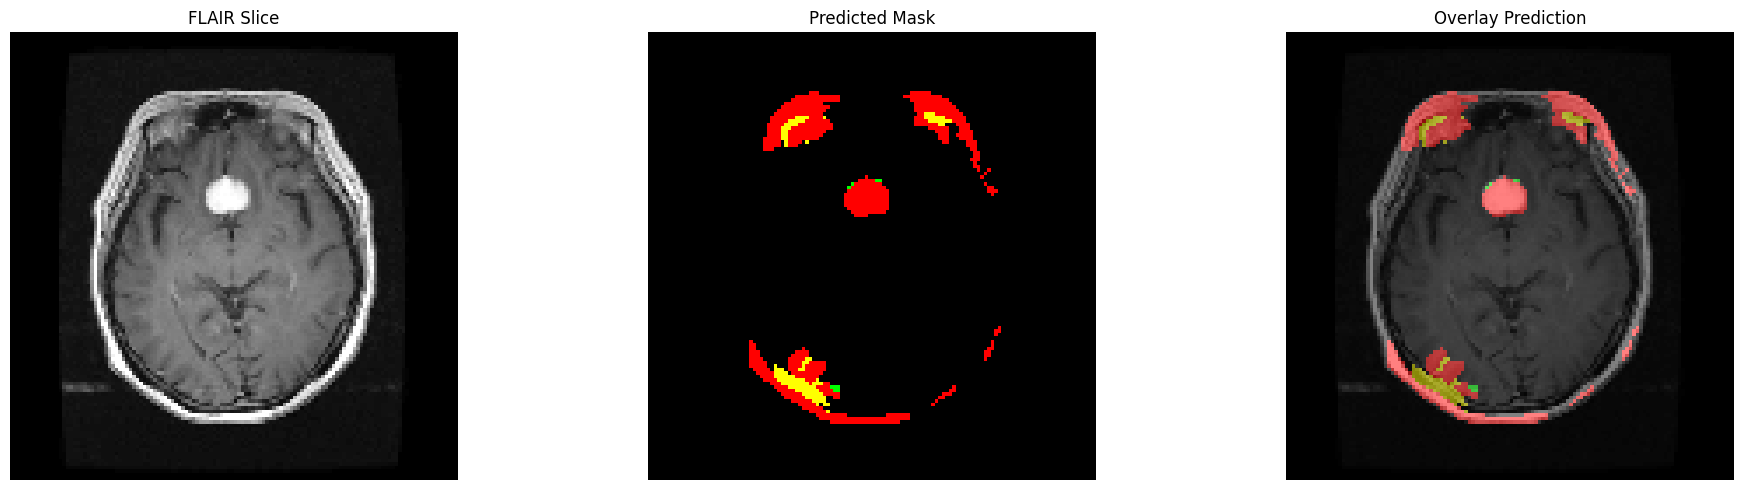

✅ Saved: /content/pred_overlay_better.jpg


In [124]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from pathlib import Path

MODEL_PATH = "/content/drive/MyDrive/GliomaScopeRX_BraTS2020_final.keras"
IMG_SIZE = 128
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# BraTS color palette
brats_colors = {
    0: (0, 0, 0),          # background
    1: (255, 255, 0),      # necrotic / non-enhancing core (yellow)
    2: (0, 255, 0),        # edema (green)
    3: (255, 0, 0)         # enhancing tumor (red)
}

def normalize_mri(img):
    img = img.astype(np.float32)
    img = np.clip(img, np.percentile(img, 1), np.percentile(img, 99))
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img = np.power(img, 0.8)  # slight gamma correction
    return img

def preprocess_image(path):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"❌ Cannot read {path}")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return normalize_mri(img)

def preprocess_mask(path):
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"❌ Cannot read mask {path}")
    return cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

def predict_mask(flair, t1ce=None):
    if t1ce is None: t1ce = flair
    X = np.stack([flair, t1ce], axis=-1)[None, ...]
    pred = model.predict(X, verbose=0)[0].argmax(axis=-1)
    return pred

def colorize_mask(mask):
    color = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, v in brats_colors.items():
        color[mask == k] = v
    return color

def overlay(image, mask, alpha=0.5):
    base = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    mask_colored = colorize_mask(mask)
    return cv2.addWeighted(base, 1 - alpha, mask_colored, alpha, 0)

print("📤 Upload FLAIR, T1CE, and (optional) GT mask:")
uploaded = files.upload()
paths = list(uploaded.keys())
flair_path = paths[0]
t1ce_path = paths[1] if len(paths) > 1 else None
gt_path = paths[2] if len(paths) > 2 else None

flair = preprocess_image(flair_path)
t1ce = preprocess_image(t1ce_path) if t1ce_path else flair
pred = predict_mask(flair, t1ce)
gt = preprocess_mask(gt_path) if gt_path else None

pred_rgb = colorize_mask(pred)
overlay_img = overlay(flair, pred)

# --- Visualization ---
fig, ax = plt.subplots(1, 4 if gt is not None else 3, figsize=(20, 5))
ax[0].imshow(flair, cmap="gray")
ax[0].set_title("FLAIR Slice")

if gt is not None:
    ax[1].imshow(colorize_mask(gt))
    ax[1].set_title("Ground Truth Mask")
    ax[2].imshow(pred_rgb)
    ax[2].set_title("Predicted Mask")
    ax[3].imshow(overlay_img)
    ax[3].set_title("Overlay Prediction")
else:
    ax[1].imshow(pred_rgb)
    ax[1].set_title("Predicted Mask")
    ax[2].imshow(overlay_img)
    ax[2].set_title("Overlay Prediction")

for a in ax: a.axis("off")
plt.tight_layout()
plt.show()

cv2.imwrite("/content/pred_overlay_better.jpg", cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR))
print("✅ Saved: /content/pred_overlay_better.jpg")

In [125]:
from google.colab import files
files.download("/content/drive/MyDrive/GliomaScopeRX_model_only.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>